In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.pipeline import Pipeline
from sklearn.model_selection import *
from sklearn.preprocessing import*
import datetime,time
from sklearn.metrics import*
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from skopt import BayesSearchCV
import re

pd.options.display.float_format = '{:.7f}'.format
pd.set_option('display.max_columns', None)

In [7]:
df= pd.read_csv('D:/project/homecredit/final/v3/final_all_onehotencoding_v3.csv',index_col=0)

In [9]:
df = df.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x.replace(' ', '')))

X = df.drop(columns=['SK_ID_CURR', 'TARGET'])
# X.to_csv('D:/project/homecredit/final/v3/final_all_onehotencoding_formodel_v3.csv')
y = df['TARGET']


In [10]:
df.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,AGE,JOB_TENURE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_365243,CNT_INSTALMENT_median,Contract_Change_rateCNT_INSTALMENT_mean,DAYS_CREDIT_ENDDATE_max,AMT_PAYMENT_MAXANNUITY_max,Contract_Change_rateCNT_INSTALMENT,DAYS_CREDIT_UPDATE_max,countSK_ID_BUREAUCREDIT_ACTIVE_Active_count,3_DAYS_ENTRY_DIFF_MEAN_mean,AMT_PAYMENT_MAX_median,AMT_PAYMENT_MAXCREDIT_max,AMT_PAYMENT_MAXCREDIT_median,DAYS_CREDIT_ENDDATE_min,CNT_INSTALMENT_max,AMT_CREDIT_SUM_DEBT_mean,Contract_Change_count,AMT_CREDIT_SUM_OVERDUE_max,AMT_CREDIT_SUM_max,PAYMENT_MAXMEDIAN_median,Contract_Change_Count_mean,AMT_PAYMENT_MEDIAN_median,DAYS_ENTRY_DIFF_MAX_max,3_DAYS_ENTRY_DIFF_MAX_mean,AMT_PAYMENT_MAX_max,6_DAYS_ENTRY_DIFF_MAX_mean,MAX_OVERDUECREDIT_mean,CNT_INSTALMENTTotal_Months_rate,PREV_DAYS_TERMINATION_min,CNT_INSTALMENTTotal_Months_rate_mean,9_DELAY_mean,PREV_NAME_YIELD_GROUP_XNA_rate,MONTHS_BALANCE_finish,PREV_GOODS_PRICECREDIT_min,OUTSTANDING_sum,DAYS_CREDIT_recent,AMT_PAYMENT_ALL_mean,countSK_ID_BUREAUCREDIT_TYPE_Microloan_count,DELAY_mean,DAYS_CREDIT_ENDDATE_median,MONTHS_BALANCE_start,AMT_CREDIT_SUM_OVERDUE_mean,DAYS_CREDIT_UPDATE_median,DAYS_ENTRY_DIFF_MEAN_mean,PREV_DAYS_LAST_DUE_min,9_DAYS_ENTRY_DIFF_MAX_mean,DAYS_CREDIT_mean,DEBTCREDIT_mean,DAYS_ENTRY_DIFF_MAX_median,DEBTCREDIT_max,AMT_ANNUITY_CASH_LOANS_MEAN,AMT_APPLICATION_CASH_LOANS_MEAN,AMT_CREDIT_CASH_LOANS_MEAN,AMT_GOODS_PRICE_CASH_LOANS_MEAN,AMT_ANNUITY_CONSUMER_LOANS_MEAN,AMT_APPLICATION_CONSUMER_LOANS_MEAN,AMT_CREDIT_CONSUMER_LOANS_MEAN,AMT_GOODS_PRICE_CONSUMER_LOANS_MEAN,AMT_ANNUITY_REVOLVING_LOANS_MEAN,AMT_APPLICATION_REVOLVING_LOANS_MEAN,AMT_CREDIT_REVOLVING_LOANS_MEAN,AMT_GOODS_PRICE_REVOLVING_LOANS_MEAN,creditcard_high,creditcard_normal,creditcard_low,instalments_overdue_DAY_mean,instalments_overdue_AMT_mean,instalments_PERIOD,BUREAU_DAYS_CREDIT,BUREAU_DAYS_CREDIT_ENDDATE,BUREAU_DAYS_ENDDATE_FACT,CDCS_ratio,bureau_annuity_mean,bereau_balance_status,NAME_CONTRACT_TYPE_Revolvingloans,CODE_GENDER_M,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Groupofpeople,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,NAME_TYPE_SUITE_Spousepartner,NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Commercialassociate,NAME_INCOME_TYPE_Maternityleave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_Stateservant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Highereducation,NAME_EDUCATION_TYPE_Incompletehigher,NAME_EDUCATION_TYPE_Lowersecondary,NAME_EDUCATION_TYPE_Secondarysecondaryspecial,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Singlenotmarried,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Houseapartment,NAME_HOUSING_TYPE_Municipalapartment,NAME_HOUSING_TYPE_Officeapartment,NAME_HOUSING_TYPE_Rentedapartment,NAME_HOUSING_TYPE_Withparents,OCCUPATION_TYPE_Cleaningstaff,OCCUPATION_TYPE_Cookingstaff,OCCUPATION_TYPE_Corestaff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HRstaff,OCCUPATION_TYPE_Highskilltechstaff,OCCUPATION_TYPE_ITstaff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_LowskillLaborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicinestaff,OCCUPATION_TYPE_Privateservicestaff,OCCUPATION_TYPE_Realtyagents,OCCUPATION_TYPE_Salesstaff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Securitystaff,OCCUPATION_TYPE_Waitersbarmenstaff,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGA

In [29]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.1, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test= scaler.transform(X_test)


迭代 10次，valid_AUC = 0.7477
迭代 20次，valid_AUC = 0.7554
迭代 30次，valid_AUC = 0.7580
迭代 40次，valid_AUC = 0.7603
迭代 50次，valid_AUC = 0.7633
迭代 60次，valid_AUC = 0.7661
迭代 70次，valid_AUC = 0.7694
迭代 80次，valid_AUC = 0.7714
迭代 90次，valid_AUC = 0.7734
迭代 100次，valid_AUC = 0.7754
迭代 110次，valid_AUC = 0.7772
迭代 120次，valid_AUC = 0.7787
迭代 130次，valid_AUC = 0.7798
迭代 140次，valid_AUC = 0.7810
迭代 150次，valid_AUC = 0.7819
迭代 160次，valid_AUC = 0.7829
迭代 170次，valid_AUC = 0.7837
迭代 180次，valid_AUC = 0.7842
迭代 190次，valid_AUC = 0.7849
迭代 200次，valid_AUC = 0.7853
迭代 210次，valid_AUC = 0.7859
迭代 220次，valid_AUC = 0.7863
迭代 230次，valid_AUC = 0.7868
迭代 240次，valid_AUC = 0.7870
迭代 250次，valid_AUC = 0.7872
迭代 260次，valid_AUC = 0.7874
迭代 270次，valid_AUC = 0.7877
迭代 280次，valid_AUC = 0.7880
迭代 290次，valid_AUC = 0.7883
迭代 300次，valid_AUC = 0.7884
迭代 310次，valid_AUC = 0.7885
迭代 320次，valid_AUC = 0.7888
迭代 330次，valid_AUC = 0.7892
迭代 340次，valid_AUC = 0.7894
迭代 350次，valid_AUC = 0.7895
迭代 360次，valid_AUC = 0.7898
迭代 370次，valid_AUC = 0.7897
迭代 380次，va

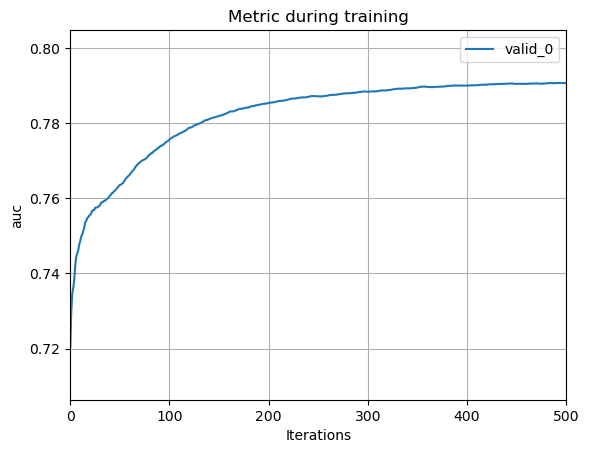

In [40]:
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_valid = lgb.Dataset(X_valid, label=y_valid, reference=lgb_train)


params = {
    # 'objective': 'binary',
    # 'is_unbalance': 'true',
    # 'metric': 'auc',
    # 'n_jobs':-1,
            'n_estimators': 500,
            'objective': 'binary',
            'is_unbalance':'true',
            'learning_rate': 0.03,
            'num_leaves': 34,
            'colsample_bytree': 0.9497036,
            'subsample': 0.8715623,
            'max_depth': 8,
            'reg_alpha': 0.041545473,
            'reg_lambda': 0.0735294,
            'min_split_gain': 0.0222415,
            'min_child_weight': 39.3259775,
            'silent': -1,
            'verbose': -1,
            'early_stop':100,
            # 'device': 'GPU'
}

evals_result = {}

start_time = time.time()

gbm = lgb.LGBMClassifier(**params)
gbm.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric=['auc','binary_logloss'],
    callbacks=[lgb.record_evaluation(evals_result)],
)


end_time = time.time()
execution_time = end_time - start_time


# After training
for iteration, auc_values in enumerate(evals_result['valid_0']['auc'], start=1):
    if iteration % 10 == 0:  # Print every 10 iterations
        print(f'迭代 {iteration}次，valid_AUC = {auc_values:.4f}')


print("程式執行花費的时间：", round(execution_time, 2), "秒")
print("完成时间:", datetime.datetime.now())

# Plot the recorded evaluation metric (AUC)
lgb.plot_metric(evals_result, metric='auc')
plt.show()


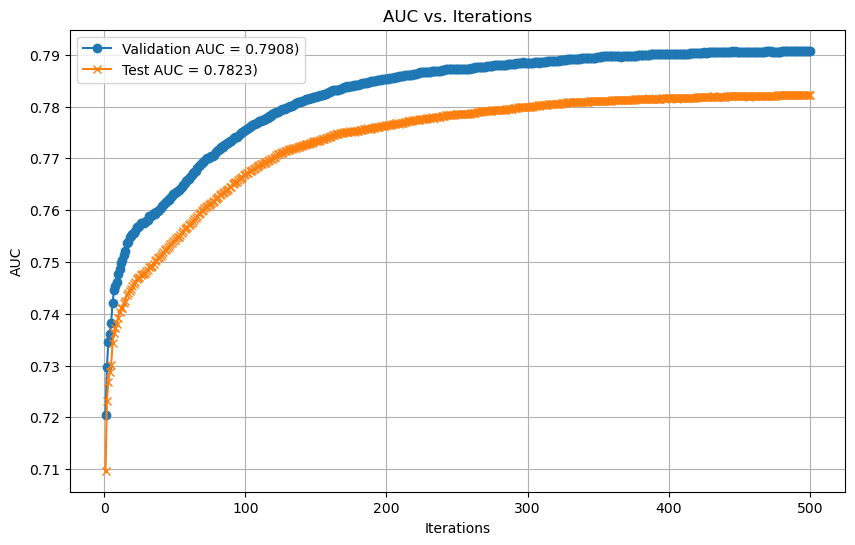

In [44]:
# 初始化验证集和测试集的真实标签
y_true_valid = y_valid
y_true_test = y_test

# 获取迭代次数和AUC值的记录
iterations = np.arange(1, len(evals_result['valid_0']['auc']) + 1)
valid_auc_values = evals_result['valid_0']['auc']

# 初始化存储AUC值的列表
valid_auc = []
test_auc = []

# 根据每个迭代次数计算验证集和测试集的AUC值
for iteration in iterations:
    # 使用模型的predict_proba方法来获取概率值
    y_pred_prob_valid = gbm.predict_proba(X_valid, num_iteration=iteration)[:, 1]
    y_pred_prob_test = gbm.predict_proba(X_test, num_iteration=iteration)[:, 1]
    
    # 计算验证集和测试集的ROC曲线
    fpr_valid, tpr_valid, _ = roc_curve(y_true_valid, y_pred_prob_valid)
    fpr_test, tpr_test, _ = roc_curve(y_true_test, y_pred_prob_test)
    
    # 计算验证集和测试集的AUC值
    roc_auc_valid = auc(fpr_valid, tpr_valid)
    roc_auc_test = auc(fpr_test, tpr_test)
    
    # 将AUC值添加到列表中
    valid_auc.append(roc_auc_valid)
    test_auc.append(roc_auc_test)

# 绘制AUC曲线
plt.figure(figsize=(10, 6))
plt.plot(iterations, valid_auc, label=f'Validation AUC = {valid_auc[-1]:.4f})', marker='o')
plt.plot(iterations, test_auc, label=f'Test AUC = {test_auc[-1]:.4f})', marker='x')
plt.xlabel('Iterations')
plt.ylabel('AUC')
plt.title('AUC vs. Iterations')
plt.legend()
plt.grid(True)
plt.show()


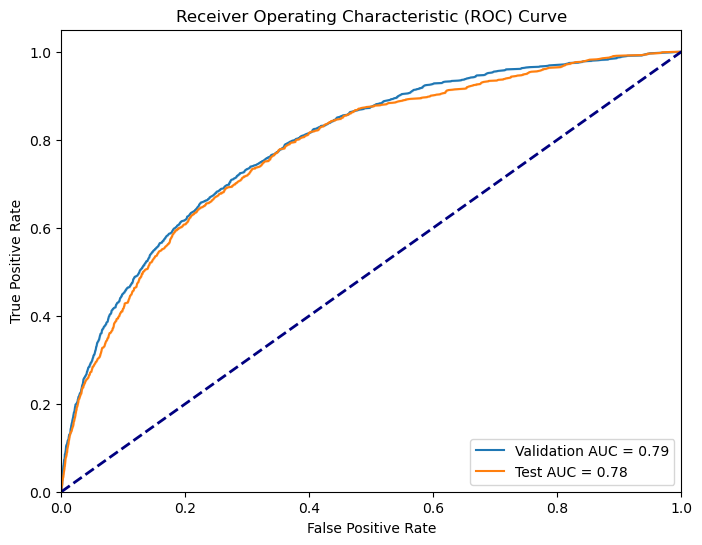

In [17]:
from sklearn.metrics import roc_curve, auc

# 初始化验证集和测试集的真实标签
y_true_valid = y_valid
y_true_test = y_test

# 使用模型的predict_proba方法来获取概率值
y_pred_prob_valid = gbm.predict_proba(X_valid)[:, 1]
y_pred_prob_test = gbm.predict_proba(X_test)[:, 1]

# 计算验证集和测试集的ROC曲线
fpr_valid, tpr_valid, _ = roc_curve(y_true_valid, y_pred_prob_valid)
fpr_test, tpr_test, _ = roc_curve(y_true_test, y_pred_prob_test)

# 计算验证集和测试集的AUC值
roc_auc_valid = auc(fpr_valid, tpr_valid)
roc_auc_test = auc(fpr_test, tpr_test)

# 创建验证集和测试集的ROC曲线数据框
roc_df_valid = pd.DataFrame({'FPR': fpr_valid, 'TPR': tpr_valid})
roc_df_test = pd.DataFrame({'FPR': fpr_test, 'TPR': tpr_test})

# 绘制AUC曲线
plt.figure(figsize=(8, 6))
sns.lineplot(data=roc_df_valid, x='FPR', y='TPR', label=f'Validation AUC = {roc_auc_valid:.2f}')
sns.lineplot(data=roc_df_test, x='FPR', y='TPR', label=f'Test AUC = {roc_auc_test:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


Confusion Matrix:
[[10293  3810]
 [  377   896]]


<Axes: >

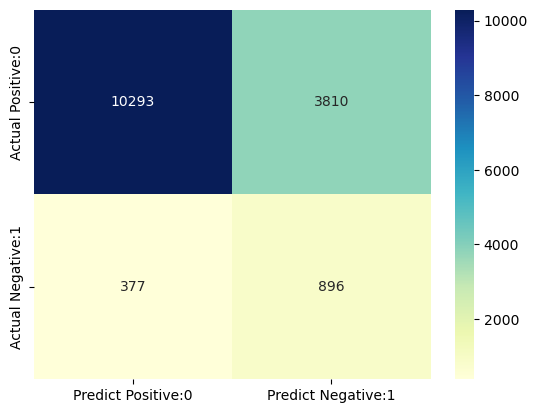

In [41]:
y_pred = gbm.predict(X_valid)

cm = confusion_matrix(y_valid, y_pred)

print("Confusion Matrix:")
print(cm)


cm_matrix = pd.DataFrame(data=cm, columns=['Predict Positive:0', 'Predict Negative:1'], 
                                 index=['Actual Positive:0', 'Actual Negative:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

<Figure size 2000x2000 with 0 Axes>

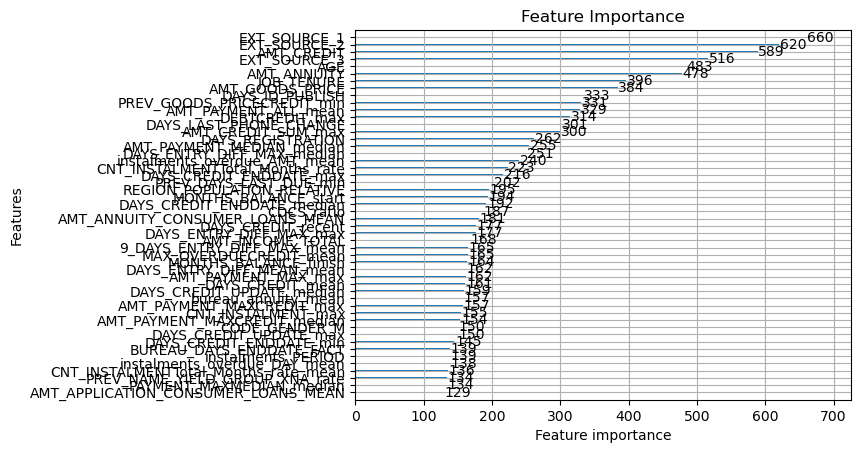

In [20]:
plt.figure(figsize=(20, 20))
lgb.plot_importance(gbm, max_num_features=50)  # Adjust max_num_features as needed
plt.title("Feature Importance")
plt.show()

In [42]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.69      0.79     14130
           1       0.08      0.31      0.13      1246

    accuracy                           0.66     15376
   macro avg       0.50      0.50      0.46     15376
weighted avg       0.85      0.66      0.74     15376



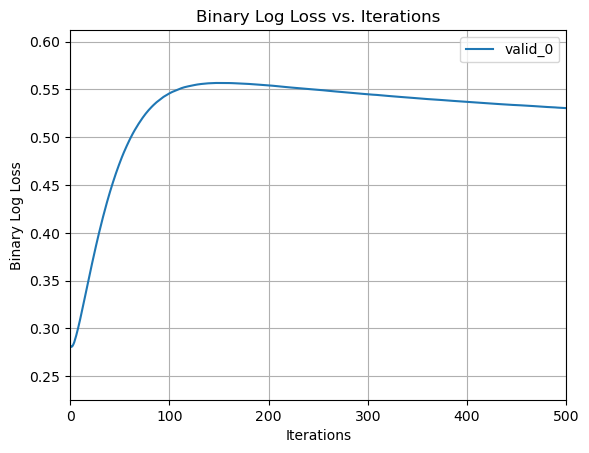

In [43]:
lgb.plot_metric(evals_result, metric='binary_logloss')
plt.xlabel('Iterations')
plt.ylabel('Binary Log Loss')
plt.title('Binary Log Loss vs. Iterations')
plt.grid(True)
plt.show()

